In [75]:
import os
import sys
# import ROOT
import uproot
import pandas as pd
import numpy as np
# import root_pandas
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, auc, roc_curve, accuracy_score, roc_auc_score

In [76]:
def TrainEval(train_DF, test_DF, var_list, n_estimators=150, max_depth=3, min_child_weight=1, seed=0):
    """ With training and testing DataFrame, and a list of variables with which to train and evaluate, produce the 
        score series for both the training and testing sets
    """
    
    # Create XGB object with the hyperparameters desired
    xgb = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth, 
                        min_child_weight=min_child_weight,
                        seed=seed)

    # Fit to the training set, making sure to include event weights
    xgb.fit(train_DF[var_list], # X
            train_DF["isSignal"], # yii
            sample_weight=train_DF["weight"], # weights
           )

    # Score the testing set
    y_score_test = xgb.predict_proba(test_DF[var_list])[:,1] # predict_proba returns [prob_bkg, prob_sig] which have the property prob_bkg+prob_sig = 1 so we only need one. Chose signal-ness
    
    # Score the training set (for overtraining analysis)
    y_score_train = xgb.predict_proba(train_DF[var_list])[:,1] # predict_proba returns [prob_bkg, prob_sig] which have the property prob_bkg+prob_sig = 1 so we only need one. Chose signal-ness
    
    # Cast the scores into pandas Series in order to connect their index to the source index
    y_score_test = pd.Series(y_score_test, index=test_DF.index) 
    y_score_train = pd.Series(y_score_train, index=train_DF.index) 
    
    return y_score_train, y_score_test

In [77]:
def PlotTemplate(train_DF, test_DF, y_score_train, y_score_test, norm=True, ax=None):
    """ Using the source DataFrames and the score Series, plot the template histograms for the training and testing sets
    """
    
    do_plot=False
    if ax==None:
        do_plot = True
        plt.clf()
        fig, ax = plt.subplots()
    
    ax.hist(y_score_test[test_DF["isSignal"] == 0], 
             weights=test_DF["weight"][test_DF["isSignal"] == 0] / (1.0 if not norm else sum(test_DF["weight"][test_DF["isSignal"] == 0])), 
             bins=10, range=(0,1), color="red", histtype="step", ls="-", label="test bkg")
    ax.hist(y_score_test[test_DF["isSignal"] == 1], 
             weights=test_DF["weight"][test_DF["isSignal"] == 1] / (1.0 if not norm else sum(test_DF["weight"][test_DF["isSignal"] == 1])), 
             bins=10, range=(0,1), color="blue", histtype="step", ls="-", label="test sig")
    ax.hist(y_score_train[train_DF["isSignal"] == 0], 
             weights=train_DF["weight"][train_DF["isSignal"] == 0] / (1.0 if not norm else sum(train_DF["weight"][train_DF["isSignal"] == 0])), 
             bins=10, range=(0,1), color="red", histtype="step", ls="--", label="train bkg")
    ax.hist(y_score_train[train_DF["isSignal"] == 1], 
             weights=train_DF["weight"][train_DF["isSignal"] == 1] / (1.0 if not norm else sum(train_DF["weight"][train_DF["isSignal"] == 1])), 
             bins=10, range=(0,1), color="blue", histtype="step", ls="--", label="train sig")
    ax.legend(loc="upper center")
    ax.set_title("%sBDT Score" % ("Normalized " if norm else ""))
    ax.set_xlabel("BDT score")
    ax.set_ylabel("Events" if not norm else "Fraction of Events")

    if do_plot:
        plt.show()

def PlotROC(train_DF, test_DF, y_score_train, y_score_test, ax=None):
    """ Compute ROC curve and ROC area for each class, and plot.
    """

    do_plot=False
    if ax==None:
        do_plot = True
        plt.clf()
        fig, ax = plt.subplots()
        
    fpr = {"test": {}, "train": {}}
    tpr = {"test": {}, "train": {}}
    roc_auc = {"test": {}, "train": {}}
    
    fpr["test"], tpr["test"], _ = roc_curve(test_DF["isSignal"], 
                                            y_score_test,#test_DF["score"],
                                            sample_weight=test_DF["weight"])
    fpr["train"], tpr["train"], _ = roc_curve(train_DF["isSignal"], 
                                              y_score_train,#train_DF["score"],
                                              sample_weight=train_DF["weight"])

    try:
        roc_auc["test"] = auc(fpr["test"], tpr["test"])
        roc_auc["train"] = auc(fpr["train"], tpr["train"])
    except:
        print("Bug in sklearn. Attempting to bypass. ROC AUC may be slightly incorrect.")
        fpr["test"], tpr["test"] = zip(*sorted(zip(fpr["test"], tpr["test"])))
        fpr["train"], tpr["train"] = zip(*sorted(zip(fpr["train"], tpr["train"])))        
        roc_auc["test"] = auc(fpr["test"], tpr["test"])
        roc_auc["train"] = auc(fpr["train"], tpr["train"])

    ax.plot(fpr["test"], tpr["test"], color='darkblue',
             lw=2, label='test ROC AUC = %0.2f' % roc_auc["test"])
    ax.plot(fpr["train"], tpr["train"], color='darkorange',
             lw=2, label='train ROC AUC = %0.2f' % roc_auc["train"])    
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(loc="lower right")
    
    if do_plot:
        plt.show()
    
def PlotROCTemplate(train_DF, test_DF, y_score_train, y_score_test):
#     plt.clf()
    fig, axs = plt.subplots(1,2,figsize=(20,8))
    PlotTemplate(train_DF, test_DF, y_score_train, y_score_test, ax=axs[0])
    PlotROC(train_DF, test_DF, y_score_train, y_score_test, ax=axs[1])
    plt.show()

In [78]:
def PlotBehavior(x, results_train, results_test, xw=7, yw=4, plot_err=True, plot_vertical=False):
    """ If given a set of results swept over some hyperparameter, plot
    """
    
    to_plot = results_test.keys()
    
    plt.clf()
    if plot_vertical:
        fig, axs = plt.subplots(len(to_plot), 1, figsize=(xw*len(to_plot), yw))
    else:
        fig, axs = plt.subplots(1, len(to_plot), figsize=(xw*len(to_plot), yw))
    
    for i, var in enumerate(to_plot):
        
        axs[i].plot(x, results_test[var][:,0], color="darkblue", label="test")
        axs[i].plot(x, results_train[var][:,0],color="darkorange", label="train")
        if plot_err:
            axs[i].fill_between(x, results_test[var][:,0] + results_test[var][:,1], 
                            results_test[var][:,0] - results_test[var][:,1],
                            color="darkblue", label="test", alpha=0.3)
            axs[i].fill_between(x, results_train[var][:,0] + results_train[var][:,1], 
                            results_train[var][:,0] - results_train[var][:,1],
                            color="darkorange", label="train", alpha=0.3)    
        axs[i].set_title(var)
        axs[i].legend(loc="best")
        axs[i].set_xlabel("Number of Estimators")
        axs[i].set_ylabel(var)
    plt.show()

In [79]:
# Using root_pandas or uproot, import TreeS and TreeB from the source root file
# TreeS doesn't seem to have sample weights, although TreeB does, 
# so we will append an arbitrary event weight to TreeS's DataFrame
# Additionally, we will add an "isSignal" variable to remember which
# is a signal sample, and which is a background sample. This can also be a string identifier.
my_file_path = "./tmva_class_example.root"
var_list = ["var1", "var2", "var3", "var4"]

# The signal tree is missing its weights branch, so we add one of all ones
# DF_sig = root_pandas.read_root(my_file_path, "TreeS") 
DF_sig = uproot.open("tmva_class_example.root")["TreeS"].pandas.df(var_list)
DF_sig = pd.concat([DF_sig, 
                    pd.DataFrame({"weight": np.ones(DF_sig.shape[0])}), 
                    pd.DataFrame({"isSignal": np.full(DF_sig.shape[0], 1)})], 
                   axis=1)

# The background dataframe already has weights, so we need those as well.
# DF_bkg = root_pandas.read_root(my_file_path, "TreeB")
DF_bkg = uproot.open("tmva_class_example.root")["TreeB"].pandas.df(var_list + ["weight"])
DF_bkg = pd.concat([DF_bkg, 
#                     pd.DataFrame({"weight": np.ones(DF_bkg.shape[0])}), 
                    pd.DataFrame({"isSignal": np.full(DF_bkg.shape[0], 0)})], 
                   axis=1)

# Combine both DFs for easy transport and manipulation
# We can access the two sets by slicing the DataFrame on the "isSignal" variable
DF = pd.concat([DF_sig, DF_bkg], axis=0)

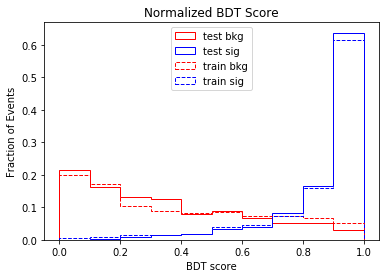

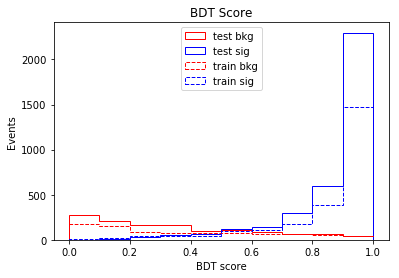

In [80]:
# Basic example: split source dataset into training and testing, train on training set, 
# evaluate on both testing and training set, and plot

train_DF, test_DF = train_test_split(DF, train_size=0.6, test_size=0.4, shuffle=True)

# START ------------------- Identical to TrainEval method -----------------------
# Create XGB object with the hyperparameters desired
xgb = XGBClassifier(n_estimators=200,
                    max_depth=3, 
                    min_child_weight=1,
                    seed=0)

# Fit to the training set, making sure to include event weights
xgb.fit(train_DF[["var1", "var2", "var3", "var4"]], # X
        train_DF["isSignal"], # y
        sample_weight=train_DF["weight"], # weights
       )

# Score the testing set
y_score_test = xgb.predict_proba(test_DF[var_list])[:,1] # predict_proba returns [prob_bkg, prob_sig] which have the property prob_bkg+prob_sig = 1 so we only need one. Chose signal-ness

# Score the training set (for overtraining analysis)
y_score_train = xgb.predict_proba(train_DF[var_list])[:,1] # predict_proba returns [prob_bkg, prob_sig] which have the property prob_bkg+prob_sig = 1 so we only need one. Chose signal-ness

# Cast the scores into pandas Series in order to connect their index to the source index
y_score_test = pd.Series(y_score_test, index=test_DF.index) 
y_score_train = pd.Series(y_score_train, index=train_DF.index) 
# END ------------------- Identical to TrainEval method -----------------------

PlotTemplate(test_DF, train_DF, y_score_test, y_score_train)
PlotTemplate(test_DF, train_DF, y_score_test, y_score_train, norm=False)

In [81]:
# Parameter sweeping example: fit multiple sets of hyperparameters and record their performance for plotting
# See GridSearchCV for scikit-learn packaged version of this functionality 
# (note -- 0.19 for scikit-learn does not support multiple scores, which means this must be rerun for each score 
# to investigate)

# Results will be stored as lists of pairs (mean, std) for each hyperparameter set
results_train = {"loss":[], "acc": [], "auc": []}
results_test = {"loss":[], "acc": [], "auc": []}

# Create our training / testing split
train_DF, test_DF = train_test_split(DF, train_size=0.6, test_size=0.4, shuffle=True)

# While sweeping our hyperparameters, we want to track the best result for plotting in the end
best_score = -999

# Select some values of n_estimators to check, and lock the other hyperparameters
max_depth = 3
min_child_weight = 5
x = range(5,105,10) + range(110,210,20) + range(300,1100,200)
for i, n_est in enumerate(x):

    # Lazy progress bar
    print(n_est,end=" ")
    
    # Calculate scores for this set of hyperparameters
    y_score_train, y_score_test = TrainEval(train_DF, 
                                            test_DF, 
                                            var_list, 
                                            n_estimators=n_est, 
                                            max_depth=max_depth,
                                            min_child_weight=min_child_weight,
                                            seed=0)

    # Record all the goodies from this iteration for plotting later. 
    # Each entry is a pair of values (mean, std). 
    # In this case, only record a single value with no std.
    results_test["loss"].append( (log_loss(test_DF["isSignal"], y_score_test, sample_weight=test_DF["weight"]),0) )
    results_train["loss"].append( (log_loss(train_DF["isSignal"], y_score_train, sample_weight=train_DF["weight"]),0) )
    results_test["acc"].append( (accuracy_score(test_DF["isSignal"], (y_score_test+0.5).astype(int), sample_weight=test_DF["weight"]),0) )
    results_train["acc"].append( (accuracy_score(train_DF["isSignal"], (y_score_train+0.5).astype(int), sample_weight=train_DF["weight"]),0) )
    results_test["auc"].append( (roc_auc_score(test_DF["isSignal"], y_score_test, sample_weight=test_DF["weight"]),0) )
    results_train["auc"].append( (roc_auc_score(train_DF["isSignal"], y_score_train, sample_weight=train_DF["weight"]),0) )
    
    # Using our chosen "best" metric, we will keep track of the best set of hyperparameters here
    # We could have a more advance metric for early stopping here, such as demanding a stop if 
    # the score doesn't improve n times in a row, or a minimum required improvement,
    # but for now we won't worry about it
    if results_test["auc"][i][0] > best_score:
        best_score = results_test["auc"][i][0] # test[auc][n_estimators][mean]
        print("New high score!: {:4.4f}".format(best_score))
        best_train_DF = train_DF
        best_test_DF = test_DF
        best_y_score_train = y_score_train
        best_y_score_test = y_score_test
        best_params = {"n_estimators":n_est, "max_depth": max_depth, "min_child_weight": max_depth}
    else:
        print("Not improved")
    
print("") # consequence of the lazy progress bar

# Numpy arrays are easier to manipulate than lists
for k in results_test.keys():
    results_test[k] = np.array(results_test[k])
    results_train[k] = np.array(results_train[k])

5 New high score!: 0.8344
15 New high score!: 0.8501
25 New high score!: 0.8606
35 New high score!: 0.8730
45 New high score!: 0.8812
55 New high score!: 0.8879
65 New high score!: 0.8919
75 New high score!: 0.8952
85 New high score!: 0.8981
95 New high score!: 0.9003
110 New high score!: 0.9025
130 New high score!: 0.9047
150 New high score!: 0.9059
170 New high score!: 0.9068
190 New high score!: 0.9070
300 New high score!: 0.9083
500 Not improved
700 Not improved
900 Not improved



Bug in sklearn. Attempting to bypass. ROC AUC may be slightly incorrect.


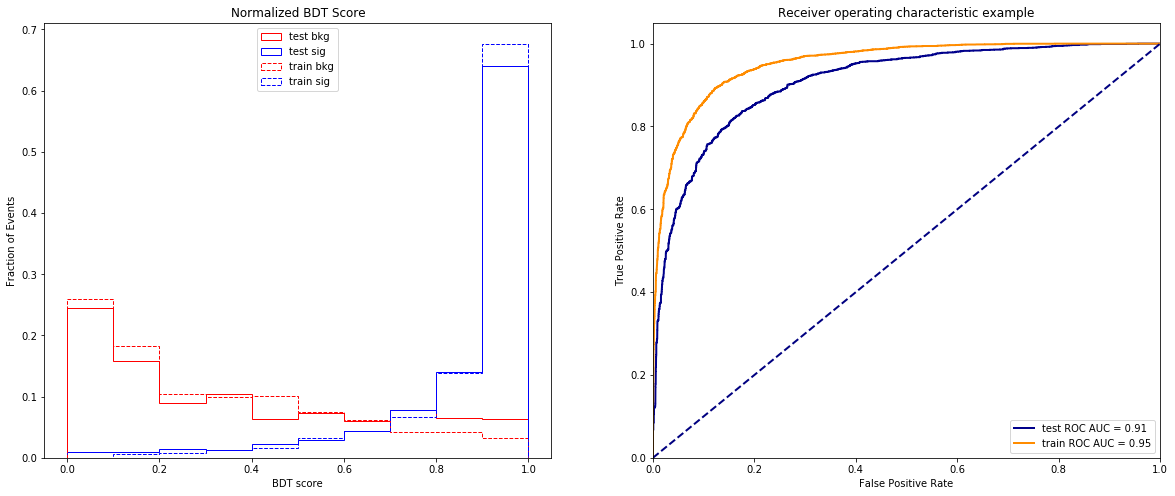

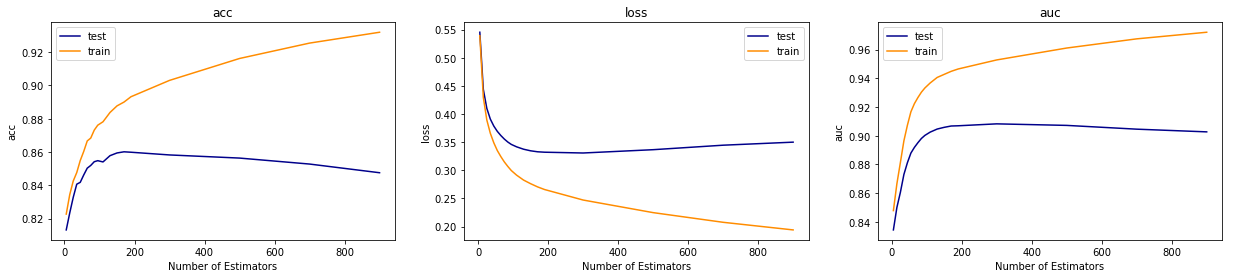

In [83]:
# Now plot everything we have for our best estimator
PlotROCTemplate(best_train_DF, best_test_DF, best_y_score_train, best_y_score_test)
# PlotTemplate(best_train_DF, best_test_DF, best_y_score_train, best_y_score_test)

# Also plot our parameter sweep
PlotBehavior(x, results_train, results_test, plot_err=False)


In [87]:
# Now let us improve our training/testing split! Instead of just splitting our set, 
# let us use KFold cross-validation.
# We will split the set into N/k sized splits, which we will then permute k times
# into training and testing sets, never allowing the sets to overlap.

# Results will be stored as lists of pairs (mean, std) for each hyperparameter set
results_train = {"loss":[], "acc": [], "auc": []}
results_test = {"loss":[], "acc": [], "auc": []}

# Instead of a simple split, we here initialize a StratifiedKFold object to shuffle and split
skf = StratifiedKFold(n_splits=3, shuffle=True)

# While sweeping our hyperparameters, we want to track the best result for plotting in the end
best_score = -999

# Select some values of n_estimators to check, and lock the other hyperparameters
max_depth = 3
min_child_weight = 5
x = range(5,105,10) + range(110,210,20) + range(300,1100,200)
for i,n_est in enumerate(x):
    
    # Lazy progress bar
    print(n_est, end=" ")
    
    # We will now have k results per set of hyperparameters, to average in the end
    this_result_train = {"loss":[], "acc": [], "auc": []}
    this_result_test  = {"loss":[], "acc": [], "auc": []}
    
    for train_index, test_index in skf.split(DF, DF["isSignal"]):


        train_DF = DF.iloc[train_index]
        test_DF = DF.iloc[test_index]    
        
        y_score_train, y_score_test = TrainEval(train_DF, 
                                                test_DF, 
                                                var_list, 
                                                n_estimators=n_est, 
                                                max_depth=max_depth,
                                                min_child_weight=max_depth,
                                                seed=0)

        # Record all the goodies from this iteration for plotting later
        this_result_test["loss"].append(log_loss(test_DF["isSignal"], y_score_test, sample_weight=test_DF["weight"]))
        this_result_train["loss"].append(log_loss(train_DF["isSignal"], y_score_train, sample_weight=train_DF["weight"]))    
        this_result_test["acc"].append(accuracy_score(test_DF["isSignal"], (y_score_test+0.5).astype(int), sample_weight=test_DF["weight"]))
        this_result_train["acc"].append(accuracy_score(train_DF["isSignal"], (y_score_train+0.5).astype(int), sample_weight=train_DF["weight"]))    
        this_result_test["auc"].append(roc_auc_score(test_DF["isSignal"], y_score_test, sample_weight=test_DF["weight"]))
        this_result_train["auc"].append(roc_auc_score(train_DF["isSignal"], y_score_train, sample_weight=train_DF["weight"]))    
    
    # Replace our recorded lists with a mean and standard deviation pair
    results_test["loss"].append((np.mean(this_result_test["loss"]), np.std(this_result_test["loss"])) )
    results_train["loss"].append((np.mean(this_result_train["loss"]), np.std(this_result_train["loss"])) )
    results_test["acc"].append((np.mean(this_result_test["acc"]), np.std(this_result_test["acc"])) )
    results_train["acc"].append((np.mean(this_result_train["acc"]), np.std(this_result_train["acc"])) )
    results_test["auc"].append((np.mean(this_result_test["auc"]), np.std(this_result_test["auc"])) )
    results_train["auc"].append((np.mean(this_result_train["auc"]), np.std(this_result_train["auc"])) )
    
    # Using our chosen "best" metric, we will keep track of the best set of hyperparameters here
    # We could have a more advance metric for early stopping here, such as demanding a stop if 
    # the score doesn't improve n times in a row, or a minimum required improvement,
    # but for now we won't worry about it
    if results_test["auc"][i][0] > best_score:
        best_score = results_test["auc"][i][0] # test[auc][n_estimators][mean]
        print("New high score!: {:4.4f} +- {:4.4f}".format(best_score, results_test["auc"][i][1]))
        best_train_DF = train_DF
        best_test_DF = test_DF
        best_y_score_train = y_score_train
        best_y_score_test = y_score_test
        best_params = {"n_estimators":n_est, "max_depth": max_depth, "min_child_weight": max_depth}
    else:
        print("Not improved")
        
print("") # consequence of the lazy progress bar

# Numpy arrays are easier to manipulate than lists
for k in results_test.keys():
    results_test[k] = np.array(results_test[k])
    results_train[k] = np.array(results_train[k])

5 New high score!: 0.8340 +- 0.0027
15 New high score!: 0.8536 +- 0.0023
25 New high score!: 0.8659 +- 0.0051
35 New high score!: 0.8769 +- 0.0020
45 New high score!: 0.8841 +- 0.0042
55 New high score!: 0.8912 +- 0.0068
65 New high score!: 0.8956 +- 0.0047
75 New high score!: 0.8994 +- 0.0022
85 New high score!: 0.8995 +- 0.0037
95 New high score!: 0.9041 +- 0.0043
110 New high score!: 0.9059 +- 0.0052
130 New high score!: 0.9068 +- 0.0043
150 New high score!: 0.9083 +- 0.0016
170 New high score!: 0.9114 +- 0.0027
190 Not improved
300 New high score!: 0.9121 +- 0.0062
500 Not improved
700 Not improved
900 Not improved



Bug in sklearn. Attempting to bypass. ROC AUC may be slightly incorrect.


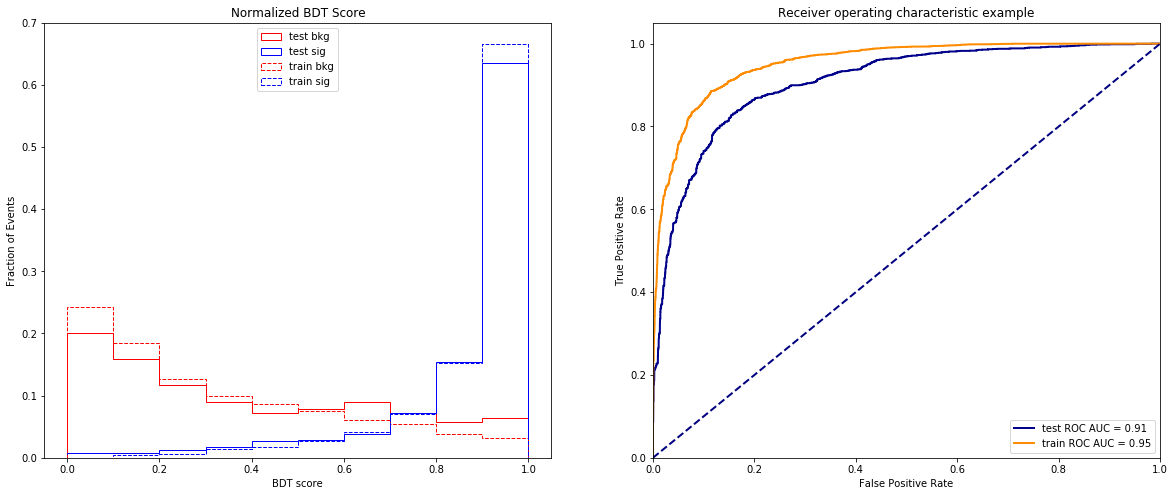

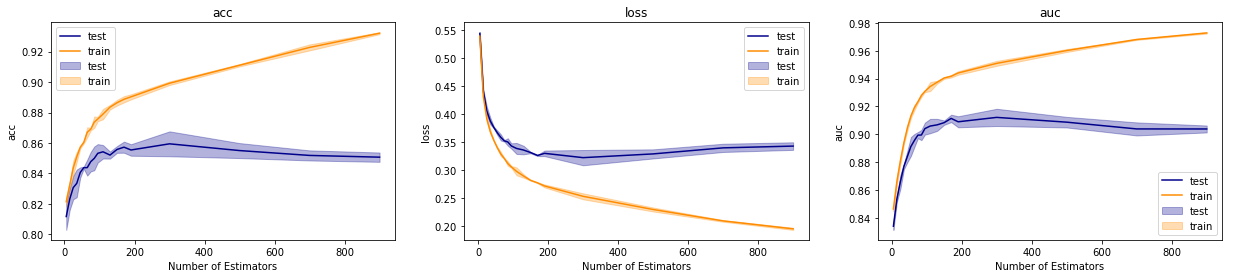

In [88]:
# Now plot everything we have for our best estimator
PlotROCTemplate(best_train_DF, best_test_DF, best_y_score_train, best_y_score_test)
# PlotTemplate(best_train_DF, best_test_DF, best_y_score_train, best_y_score_test)

# Also plot our parameter sweep
PlotBehavior(x, results_train, results_test, plot_err=True)

In [89]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [90]:
# Basic example: split source dataset into training and testing, train on training set, 
# evaluate on both testing and training set, and plot
def TrainEvalPlot(DF, var_list,n_est,max_depth=3,min_child_weight=1):
    train_DF, test_DF = train_test_split(DF, train_size=0.6, test_size=0.4, shuffle=True)

    y_score_train, y_score_test = TrainEval(train_DF, 
                                            test_DF, 
                                            var_list, 
                                            n_est, 
                                            max_depth=max_depth,
                                            min_child_weight=max_depth,
                                            seed=0)

    PlotROCTemplate(train_DF, test_DF, y_score_train, y_score_test)
#     PlotTemplate(test_DF, train_DF, y_score_test, y_score_train)

In [95]:
interactive_plot = widgets.interactive(TrainEvalPlot, 
         DF=fixed(DF),
         var_list=fixed(var_list),
         n_est=widgets.IntSlider(min=10,max=1000,step=10, continuous_update=False),
         max_depth=widgets.IntSlider(min=1,max=10,step=1, continuous_update=False),
         min_child_weight=widgets.IntSlider(min=0,max=10,step=1, continuous_update=False),                                        
        )

output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot

Widget Javascript not detected.  It may not be installed or enabled properly.
